<a href="https://colab.research.google.com/github/MehrdadJalali-AI/RecommenderSystems/blob/main/Zero_Shot_Generative_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Zero-Shot / Generative Recommender

**Notebook:** Zero-Shot_Generative_Recommender.ipynb  

---

### 🎯 Learning Goals
In this exercise, we demonstrate how **zero-shot** and **generative embedding** techniques can be used to build recommenders capable of reasoning about unseen items or missing information.

- Use **Sentence-Transformer** embeddings for semantic similarity between text descriptions.  
- Use **Flan-T5** to generate missing item descriptions.  
- Combine both models to enable zero-shot recommendations.  
- Visualize semantic relationships in the embedding space.

---



## Step 1 – Setup and Installation

We install the required libraries for sentence embeddings and text generation.


In [1]:

!pip install -q sentence-transformers transformers scikit-learn matplotlib



## Step 2 – Import Required Libraries


In [2]:

from sentence_transformers import SentenceTransformer
from transformers import pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



## Step 3 – Define a Small Movie Dataset

We create a small dataset of movies. Some descriptions are **missing**, simulating a real-world cold-start scenario.


In [4]:

movies = pd.DataFrame({
    'title': [
        'Interstellar',
        'Inception',
        'The Dark Knight',
        'Finding Nemo',
        'The Notebook',
        'Spirited Away'
    ],
    'description': [
        'A team of explorers travels through a wormhole in space to ensure humanity’s survival.',
        None,
        'Batman faces the Joker in Gotham City, exploring chaos and morality.',
        None,
        'A romantic drama between two lovers separated by social class.',
        'A young girl discovers a magical world ruled by spirits and gods.'
    ]
})

print("Initial dataset with missing descriptions:")
display(movies)


Initial dataset with missing descriptions:


,title,description
0,Interstellar,A team of explorers travels through a wormhole...
1,Inception,None
2,The Dark Knight,"Batman faces the Joker in Gotham City, explori..."
3,Finding Nemo,None
4,The Notebook,A romantic drama between two lovers separated ...
5,Spirited Away,A young girl discovers a magical world ruled b...



## Step 4 – Generate Missing Descriptions Using Flan-T5

We use Google's **Flan-T5** model (a lightweight open-source LLM) to generate short descriptions for the movies that lack one.

This illustrates how **generative models** can enrich a recommender’s knowledge base, helping to describe unseen or new items.


In [5]:

generator = pipeline("text2text-generation", model="google/flan-t5-base")

def generate_description(title):
    prompt = f"Generate a short movie description for '{title}'"
    return generator(prompt, max_new_tokens=40)[0]['generated_text']

movies['description'] = movies.apply(
    lambda row: row['description'] if pd.notna(row['description']) else generate_description(row['title']), axis=1
)

print("Completed dataset with generated text:")
display(movies)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cpu


Completed dataset with generated text:


,title,description
0,Interstellar,A team of explorers travels through a wormhole...
1,Inception,"inception is a spooky , spooky , spooky , spoo..."
2,The Dark Knight,"Batman faces the Joker in Gotham City, explori..."
3,Finding Nemo,"'Finding Nemo' is a spooky, spooky, spooky, sp..."
4,The Notebook,A romantic drama between two lovers separated ...
5,Spirited Away,A young girl discovers a magical world ruled b...



## Step 5 – Compute Sentence Embeddings

We use the **all-MiniLM-L6-v2** model from *SentenceTransformers* to encode all movie descriptions (both original and generated) into fixed-size vectors.

Each vector captures the movie’s semantic meaning, enabling similarity-based retrieval.


In [6]:

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(movies['description'].tolist(), show_progress_bar=True)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


## Step 6 – Zero-Shot Query Function

Given a natural-language query (e.g., *"a mind-bending science fiction movie"*), we encode it into the same embedding space and compute **cosine similarity** with movie embeddings.


In [7]:

def zero_shot_query(prompt, top_n=3):
    query_emb = model.encode([prompt])
    sims = cosine_similarity(query_emb, embeddings)[0]
    top_idx = np.argsort(sims)[::-1][:top_n]
    recs = [(movies.iloc[i]['title'], round(sims[i], 3)) for i in top_idx]
    return recs



## Step 7 – Try Example Queries
We provide two sample prompts and observe how the recommender system retrieves the most semantically related movies.


In [8]:

query_1 = "a mind-bending science fiction movie about dreams"
query_2 = "a romantic story with emotional depth"

print("Zero-Shot Recommendation for Query 1:", query_1)
for rec in zero_shot_query(query_1):
    print(rec)

print("\nZero-Shot Recommendation for Query 2:", query_2)
for rec in zero_shot_query(query_2):
    print(rec)


Zero-Shot Recommendation for Query 1: a mind-bending science fiction movie about dreams
('Inception', np.float32(0.345))
('Finding Nemo', np.float32(0.262))
('The Notebook', np.float32(0.231))

Zero-Shot Recommendation for Query 2: a romantic story with emotional depth
('The Notebook', np.float32(0.596))
('Spirited Away', np.float32(0.186))
('The Dark Knight', np.float32(0.152))



## Step 8 – Visualize Embeddings in 2D

We project both movie and query embeddings into a 2D space using **PCA**.  
The proximity between the query points (in red) and the movies (in blue) reflects their semantic similarity.


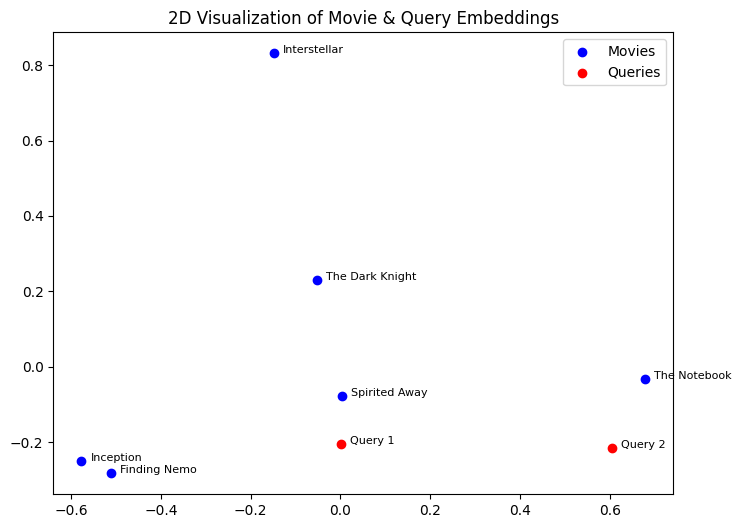

In [9]:

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(np.vstack([embeddings, model.encode([query_1, query_2])]))

plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:-2,0], emb_2d[:-2,1], color='blue', label='Movies')
plt.scatter(emb_2d[-2:,0], emb_2d[-2:,1], color='red', label='Queries')
for i, title in enumerate(list(movies['title']) + ["Query 1", "Query 2"]):
    plt.text(emb_2d[i,0]+0.02, emb_2d[i,1], title, fontsize=8)
plt.title("2D Visualization of Movie & Query Embeddings")
plt.legend()
plt.show()



## Step 9 – Discussion

### 🧠 Key Insights
- **Zero-Shot Retrieval:** The system generalizes to unseen items without additional training.  
- **Generative Enrichment:** Missing textual features can be synthesized using LLMs to reduce the cold-start problem.  
- **Semantic Alignment:** Both user queries and item descriptions exist in the same embedding space, enabling text-based recommendation.  

### 🔍 Applications
- Cold-start recommendation (new items without history).  
- Hybrid text–embedding search in media and e-learning platforms.  
- Intelligent assistants capable of reasoning with descriptive text.  

---

> *By integrating LLMs with embedding models, modern recommenders gain both creativity (generation) and reasoning (semantic matching).*
